### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 3     

In [1]:
from util.VisualizeDataset import VisualizeDataset
from Chapter3.DataTransformation import LowPassFilter
from Chapter3.DataTransformation import PrincipalComponentAnalysis
from Chapter3.ImputationMissingValues import ImputationMissingValues
from Chapter3.KalmanFilters import KalmanFilters
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

In [2]:
# Let is create our visualization class again.
DataViz = VisualizeDataset()

dataset_path = 'intermediate_datafiles/'
try:
    dataset = pd.read_csv(dataset_path + 'all_data_converted.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e
    
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000

In [3]:
LowPass = LowPassFilter()

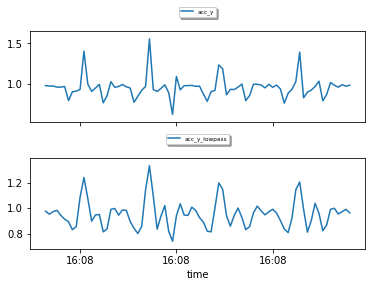

In [7]:
# Determine the sampling frequency.
fs = float(1000)/milliseconds_per_instance
cutoff = 1.5
# Let us study acc_phone_x:
new_dataset = LowPass.low_pass_filter(copy.deepcopy(dataset), 'acc_y', fs, cutoff, order=10)
DataViz.plot_dataset(new_dataset[(new_dataset.labelBenchPress == 1)][:80], ['acc_y', 'acc_y_lowpass'], ['exact','exact'], ['line', 'line'])

In [8]:
# And now let us include all measurements that have a form of periodicity (and filter them):
periodic_measurements = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

for col in periodic_measurements:
    dataset = LowPass.low_pass_filter(dataset, col, fs, cutoff, order=10)
    dataset[col] = dataset[col + '_lowpass']
    del dataset[col + '_lowpass']

In [9]:
# Determine the PC's for all but our target columns (the labels and the heart rate)
# We simplify by ignoring both, we could also ignore one first, and apply a PC to the remainder.

PCA = PrincipalComponentAnalysis()
selected_predictor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
pc_values = PCA.determine_pc_explained_variance(dataset, selected_predictor_cols)

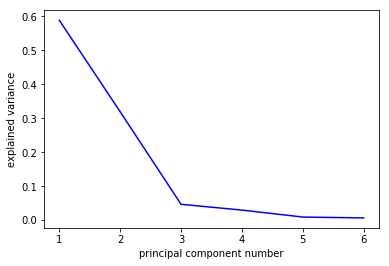

In [10]:
# Plot the variance explained.

plot.plot(range(1, len(selected_predictor_cols)+1), pc_values, 'b-')
plot.xlabel('principal component number')
plot.ylabel('explained variance')
plot.show(block=False)

In [11]:
# We select 4 as the best number of PC's as this explains most of the variance

n_pcs = 3
dataset = PCA.apply_pca(copy.deepcopy(dataset), selected_predictor_cols, n_pcs)

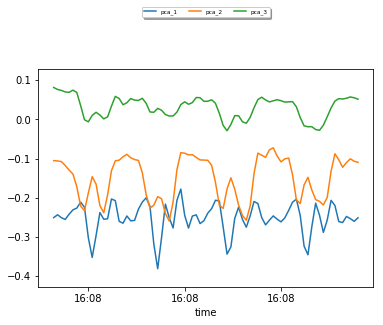

In [12]:
#And we visualize the result of the PC's
DataViz.plot_dataset(dataset[(dataset.labelBenchPress == 1)][:80], ['pca_'], ['like'], ['line'])

In [14]:
dataset.to_csv(dataset_path + 'chapter3_result_final.csv')